# Inflation and Unemployment in the Long Run

*Author: Mohammed Aït Lahcen, University of Basel*

In this notebook I replicate some results from Berentsen et al. (AER, 2011). This paper studies the long-run relationship between monetary policy and the labor market. Monetary policy affects output and employment through the real balance effect: Higher inflation increases the cost of money carried for transaction purposes which lowers consumption and output, reduces firms' profits and job creation and increases unemployment. Matching frictions in the goods market work as an amplification mechanism.

In [1]:
import numpy as np
from matplotlib import rcParams
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import scipy.optimize as opt
import scipy.interpolate as interp
from scipy.integrate import quad as integrate
from scipy.misc import derivative
from numba import jit

import seaborn as sns  # Better quality figures
%matplotlib notebook
# Displays figures inside the notebook
from matplotlib import cm
from mpl_toolkits.mplot3d.axes3d import Axes3D
rcParams['figure.figsize'] = (12, 8)  # Sets the size of the figures in the notebook

## Data

We start by importing the data used for the calibration and simulation parts. This consists on quarterly time series over the period 1955-2005 for:
* Money demand (M1/Nominal GDP, annualized)
* Interest rate (AAA corporate bonds, annualized, percent)
* Inflation (annualized, percent)
* Unemployment (percent)

In [2]:
data = pd.read_csv('exportable_data.csv', sep=',', names=['M1/PY', 'unemployment', 'i-AAA', 'inflation'])

data = data.drop(data.index[:28])  # Drop data before 1955

print(data.count(axis=0))

m_data = data['M1/PY']  # Money demand
u_data = data['unemployment'] / 100
p_data = ((1 + (data['inflation'] / 100)) ** (1 / 4)) - 1  # Transform into quarterly series
i_ann_data = data['i-AAA'] / 100
i_data = ((1 + (data['i-AAA'] / 100)) ** (1 / 4)) - 1  # Transform into quarterly rates

M1/PY           204
unemployment    204
i-AAA           204
inflation       204
dtype: int64


Next, we extract the long run component of the data using an HP-filter with paramater set at 1600 as is usual in the literature.

In [3]:
m_cycle, m_trend = sm.tsa.filters.hpfilter(m_data, 1600)
u_cycle, u_trend = sm.tsa.filters.hpfilter(u_data, 1600)
i_cycle, i_trend = sm.tsa.filters.hpfilter(i_data, 1600)
p_cycle, p_trend = sm.tsa.filters.hpfilter(p_data, 1600)

Below, I replicate figure 1 of the paper.

<IPython.core.display.Javascript object>


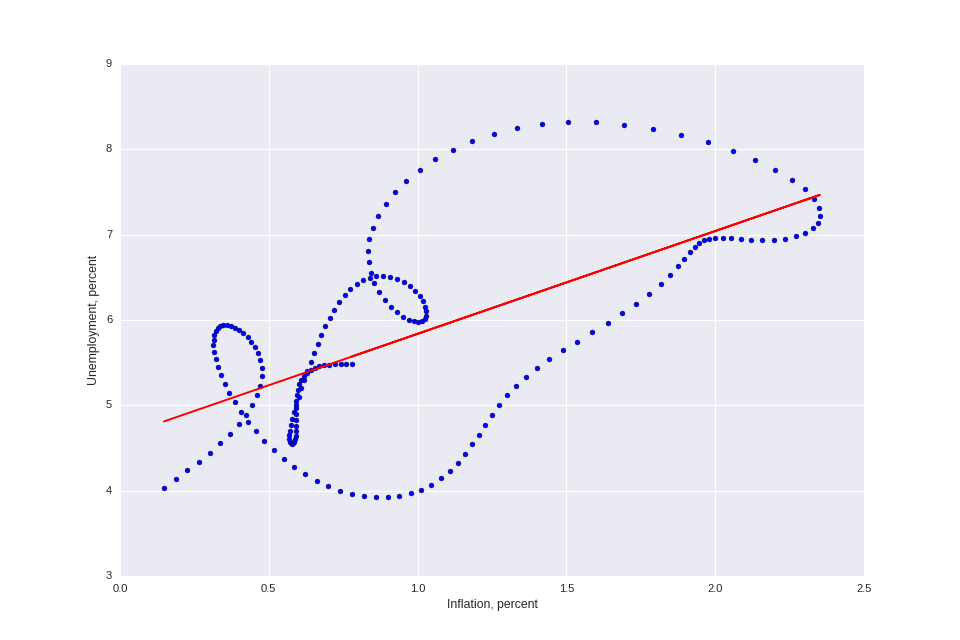

In [4]:
plt.figure(1)
results = sm.OLS(u_trend, sm.add_constant(p_trend),missing='drop').fit()
a, b = results.params
plt.plot(p_trend*100, (a + b*p_trend)*100,'r')
plt.scatter(p_trend*100,u_trend*100)
plt.xlabel('Inflation, percent')
plt.ylabel('Unemployment, percent')
#plt.xlim(0,0.03)
#plt.ylim(0,0.10)
plt.show()

Next, I compute some moments of the data that will be used later as targets in the calibration part.

In [5]:
m_mean = np.mean(m_data)
i_mean = np.mean(i_data)
p_mean = np.mean(p_data)
u_mean = np.mean(u_data)

print('m_mean =','{:04.2f}'.format(m_mean*100),'%')
print('i_mean =','{:05.2f}'.format(i_mean*100),'%')
print('p_mean =','{:05.2f}'.format(p_mean*100),'%')
print('u_mean =','{:05.2f}'.format(u_mean*100),'%')

m_mean = 17.89 %
i_mean = 01.80 %
p_mean = 00.98 %
u_mean = 05.81 %


I also estimate money demand elasticity based on the annualized unfiltered data using a log-log specification: $\log(m) = \alpha + \beta\log(i)$:

In [6]:
results = sm.OLS(np.log(m_data), sm.add_constant(np.log(data['i-AAA']))).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  M1/PY   R-squared:                       0.470
Model:                            OLS   Adj. R-squared:                  0.467
Method:                 Least Squares   F-statistic:                     179.1
Date:                Wed, 28 Dec 2016   Prob (F-statistic):           1.16e-29
Time:                        19:36:42   Log-Likelihood:                 21.809
No. Observations:                 204   AIC:                            -39.62
Df Residuals:                     202   BIC:                            -32.98
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         -0.6873      0.082     -8.367      0.0

In [7]:
MDela = results.params[1]  # extract money demand elasticity
print('Estimated Money demand elasticity = ',MDela)

Estimated Money demand elasticity =  -0.556520791275


## Parameters and functional forms

In order to simulate the model, the authors use the following functional forms:

**Preferences:**
* $u(q)= A \dfrac{q^{1-\alpha}}{1-\alpha}$, the household's utility function for the cash good
* $\beta$, the household's discount factor;
* $b$, the household's productivity at home.

**Technology:**
* $c(q) = G q^\gamma$, the firm's cost of producing the cash good;
* $y$, the firm's production of the credit good;
* $k$, the firm's cost from creating a vacancy;
* $\delta$, the job-destruction probability.

**Labor Market:**
* $p(\theta) = \min\{Z \theta^\sigma,1\}$, job-finding probability as a function of the vacancy/unemployment ratio;
* $\eta$, bargaining share of the firm in the wage bargaing;

**Goods Market:**
* $m(b/s) = \min\{M (s/b)^\psi,1\}$, seller-finding probability as a function of the seller/buyer ratio;
* $\phi$, bargaining share of the seller.

I use the same parameter values used by the authors in their base calibration:

In [8]:
A = 1.08
alpha = 0.179
beta = 0.992  # discount factor
delta = 0.05  # exogenous job destruction rate
Z = 0.364  # Parameter of labor market matching function
sigma = 0.28  # Parameter of labor market matching function (Hosios condition used)
eta = 0.28  # wage bargaining power of firm
k = 0.000844  # cost of vacancy posting
G = 1  #
gamma = 1
phi = 0.725  # bargaining power of seller
uben = 0.55  # unemployment benefits
leis = 0.50
b = uben + leis  # home productivity (unemployment benefits + leisure)
y = 1  # firm production of the general good

u_max = 0.3
u_min = delta / (1 + delta)

i_max = max(i_data)
i_min = max(min(i_data), 0.0001)

In [11]:
%qtconsole

and the functional forms:

In [10]:
def util(q):
    """
    Utility of consuming q amount of the search good
    """
    
    return A * (q ** (1 - alpha)) / (1 - alpha)


def dutil(q):
    """
    First derivative of util(q)
    """
    
    return A * q ** (-alpha)


def c(q):
    """
    Cost of producing q amount of the search good
    """
    
    return G * q ** gamma


def dc(q):
    """
    First derivative of c(q)
    """
    
    return gamma * G * q ** (gamma - 1)


def p(theta):
    """
    Job-finding probability as a function of the vacancy/unemployment ratio
    """
    
    return Z * theta ** sigma


def m(s):
    """
    Seller-finding probability as a function of the seller/buyer ratio
    """
    
    return s / (1 + s)

## Model in the Steady State

First we implement the steady state version of the model:

* **Decentralized Market (KW)**

From the Nash bargaining solution to the tems of trade we get the following money holdings function:
    
$$
g(q) = \frac{\theta u'(q) c(q) + (1-\theta) c'(q) u(q)}{\theta u'(q) + (1- \theta) c'(q)}
$$

The optimal quantity $q^*$ satisfies the following LW curve:

$$
\frac{u'(q^*)}{g'(q^*)} = 1 + \frac{i}{\mathcal{M}(1,1-u)}
$$

In [12]:
@jit
def g(q):  
    """
    Pricing function resulting from the Nash bargaining solution
    """
    
    return ((1 - phi) * c(q) * dutil(q) + phi * dc(q) * util(q)) / ((1 - phi) * dutil(q) + phi * dc(q))


def dg(q):  
    """
    First derivative of g(q)
    """
    
    return derivative(g, q, dx=1e-6, n=1)


@jit
def lw_curve(q, i, u):  
    """
    LW curve equation linking q, u and i
    """
    
    return dutil(q) - (1 + (i / (min(m(1 - u),1)))) * dg(q)


def q_ss(i, u):  
    """
    Returns the steady state q that satisfies LW curve equation given i and u
    """

    return opt.root(lw_curve, 10 ** (-3), args=(i,u), method='lm').x

* **Labor Market (MP)**

$$
k = \frac{\eta \frac{\mathcal{N}(u,v)}{v} \left(y - b - \ell + \frac{\mathcal{M}(1,1-u)}{1-u}(g(q) - c(q))\right)}{r + \delta + (1-\eta)\frac{\mathcal{N}(u,v)}{u}}
$$

where $v = v(u)$ is pinned down by the steady state condition : $(1-u)\delta = \mathcal{N}(u,v)$ (matches destroyed = matches created).

Let $\theta = \dfrac{v}{u}$ be the labor market tightness. We have then:

$$
\lambda_h = \dfrac{\mathcal{N}(u,v)}{u} = \mathcal{N}(1,\theta) = Z \theta^{\sigma} = p(\theta)
$$ and 
$$
\lambda_f = \dfrac{\mathcal{N}(u,v)}{v} = \mathcal{N}(1/\theta,1) = \dfrac{Z \theta^{\sigma}}{\theta} = \dfrac{p(\theta)}{\theta}
$$

Hence from the steady state condition we have: $\theta_{SS} = \left( \dfrac{(1-u)\delta}{Zu} \right)^{1/\sigma}$

In [13]:
def y_ss(i, u):
    """
    Returns the steady state one period revenues generated by a firm given the state (i,u)
    """
    
    return y + min(m(1 - u) / (1 - u),1) * (g(q_ss(i, u)) - c(q_ss(i, u)))


def theta_ss(u):
    """
    Returns the steady state value of labor market tightness theta as a function of u
    """
    
    return (((1 - u) * delta) / (Z * u)) ** (1 / sigma)


@jit
def beveridge_curve(u, i): 
    """
    Beveridge curve equation determining firm entry level which exhausts the rent of posting a vacancy
    u is the first argument because it's solved for in u_ss
    """
    
    return k - (min(p(theta_ss(u))/theta_ss(u),1) * eta * (y_ss(i, u) - b)) / (((1 / beta) - 1) + delta + (1 - eta) * min(p(theta_ss(u)),1))


def u_ss(i):
    """
    Returns the steady state level of unemployment that satisfies the beveridge curve for a given i
    """
        
    return opt.root(beveridge_curve, 10 ** (-3), args = i, method='lm').x

### Plotting the Long Run Philips Curve

In order to plot the LRPC, we must define th grids for the nominal interest rate $i$ and the unemployment rate $u$:

In [14]:
i_grid = np.linspace(i_min, i_max, num=100)
u_grid = np.linspace(u_min, u_max, num=100)

Next, we plot the LRPC by passing the grid of $i$ to the Beveridge curve and solving for the corresponding steady state $u$:

<IPython.core.display.Javascript object>


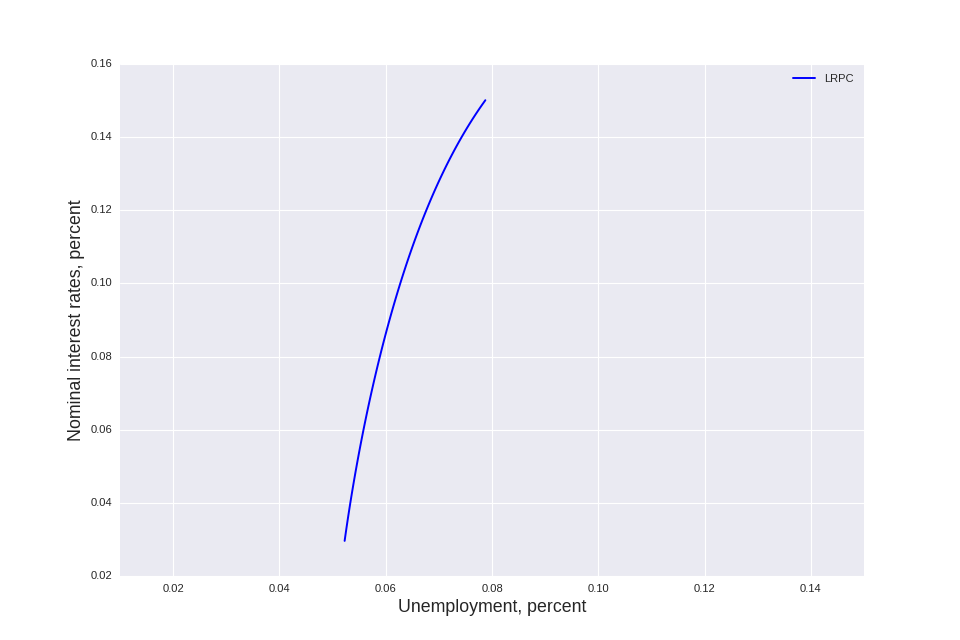

In [15]:
x0 = [u_ss(i) for i in i_grid]
x1 = [(i+1)**4-1 for i in i_grid]

plt.figure()
plt.plot(x0, x1, 'b-', label='LRPC')
plt.xlim(0.01,0.15)
#plt.ylim(-0.5,2)
plt.xlabel('Unemployment, percent',fontsize=16)
plt.ylabel('Nominal interest rates, percent',fontsize=16)
plt.legend(loc='best')
plt.show()

### Plotting the Money Demand Curve

The demand for real balances in the model results from trades occuring in the DM. It depends on the cos

The money demand relationship in the model is:
$$
\frac{M}{pY} = \frac{M/p}{Y} = \frac{g(q)}{4(1 - u)\left( \alpha_f (g(q) - c(q)) + y \right)}
$$

In [16]:
def MD(i):
    """
    Returns Money Demand as a function of i
    """
    
    return g(q_ss(i,u_ss(i))) / (4 * (1 - u_ss(i)) * y_ss(i,u_ss(i)))

<IPython.core.display.Javascript object>


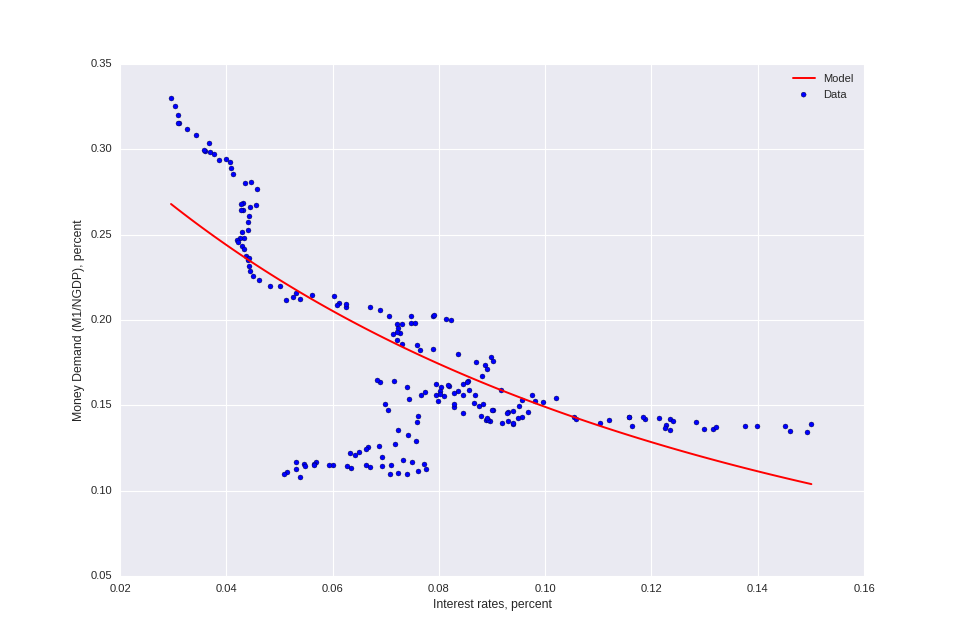

In [17]:
x0 = [(i+1)**4-1 for i in i_grid]
x1 = [MD(i) for i in i_grid]

plt.figure()
plt.plot(x0, x1, 'r-', label='Model')
plt.scatter(i_ann_data,m_data, label='Data')
#plt.xlim(0.01,0.15)
#plt.ylim(-0.5,2)
plt.xlabel('Interest rates, percent')
plt.ylabel('Money Demand (M1/NGDP), percent')
plt.legend(loc='best')
plt.show()

Next, I calculate the model based interest rate elasticity of money:

In [18]:
results2 = sm.OLS(np.log(x1), sm.add_constant(np.log(x0))).fit()
print(results2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                     3450.
Date:                Wed, 28 Dec 2016   Prob (F-statistic):           3.39e-78
Time:                        19:42:32   Log-Likelihood:                 166.31
No. Observations:                 100   AIC:                            -328.6
Df Residuals:                      98   BIC:                            -323.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         -3.3335      0.026   -126.274      0.0

In [19]:
MDela_model = results2.params[1]  # extract money demand elasticity
print('Estimated Money demand elasticity based on model data = ',MDela_model)

Estimated Money demand elasticity based on model data =  -0.608189266923


The resulting value is close to the value observed in the data (-0.55). This is of course a result of the calibrated values for the utility parameters.

## Model with Monetary Shocks

In order to solve and simulate the model with monetary shocks, the authors formulate the stochastic version of the model in a recursive fashion.

The state vector is $s = (u, i)$ where $u$ and $i$ follow different laws of motion:

$$
\hat{i} = \bar{i} + \rho_i (i - \bar{i}) + \epsilon_i, \quad \epsilon_i \sim \mathcal{N}(0,\sigma_{\epsilon_i})
\\
\hat{u}(s) = u - u \lambda_h(\theta(s)) + (1 - u)\delta
$$

<br>
**The recursive equilibrium is formulated as:**
* Bellman equation for the match surplus:
$$
S(s) = y - b - \ell + \alpha_f(\frac{1}{1 - \hat{u}(s)}) \left(g(q(s)) - c(q(s))\right) + \beta \mathbb{E}\left[(1 - \delta - (1 - \eta)\lambda_h(\theta(\hat{s})) S(\hat{s})\right]
$$
* LW curve:
$$
1 = \frac{v'(q(s))}{g'(q(s))} - \frac{i}{\alpha_h(\frac{1}{1 - \hat{u}(s)})}
$$
* Free entry condition:
$$
k = \beta \lambda_f(\theta(s))\eta S(s)
$$

#### Discretizing the Stochastic process for $i$

In the US data, the quarterly nominal interest rate of AAA bonds exhibits the following moments:

In [20]:
i_mean = np.mean(i_data)
i_acr = sm.tsa.stattools.acf(i_data,unbiased = True, nlags=1)[1]
i_std = np.std(i_data)

print('Average interest rate =','{:05.2f}'.format(i_mean*100),'%')
print('1st order autocorrelation =','{:05.2f}'.format(i_acr*100),'%')
print('Standard deviation =','{:05.2f}'.format(i_std*100),'%')

Average interest rate = 01.80 %
1st order autocorrelation = 98.62 %
Standard deviation = 00.63 %


As stated above, the nominal interest rate is assumed to follow the process:
$$
\hat{i} = \bar{i} + \rho_i (i - \bar{i}) + \epsilon_i, \quad \epsilon_i \sim \mathcal{N}(0,\sigma_{\epsilon_i})
$$

The unconditional variance of the stationary distribution of $i$ is: $ \sigma_i^2 = \dfrac{\sigma_{\epsilon_i}^2}{(1 - \rho_i^2)}$ and $\hat{i}$ conditional on $i$ follows the distribution $\mathcal{N}(\bar{i} + \rho_i (i - \bar{i}),\sigma_{\epsilon_i})$.

Taking $\sigma_i$ and $\rho_i$ from the data, the standard deviation of the process error term is defined as follows:
$$
\sigma_{\epsilon_i} = \sigma_i (1 - \rho_i^2)^{1/2}
$$

To simulate the model with shocks, we can either use an approximation of the value function or a discretization of the state space of $i$. We will proceed with the second option using Tauchen (1986) method to approximate the continuous state AR(1) process by a finite state Markov chain with state space $\{i_0,...,i_{n-1}\}$ and transition matrix $P$:

1. Construct a $n$ points grid (state space) of values for $i$ with the following assigned values:
    * $i_0 = -m \sigma_i$
    * $i_{n-1} = m \sigma_i$
    * $i_j = i_{j-1} + s$ where $s = \dfrac{i_{n-1} + i_0}{n-1}$ where $F$ is the cdf of the normal distribution $\mathcal{N}(0,\sigma_{\epsilon_i})$
2. Assign the following probabilities $P(i_k,i_j)$ to the grid point $i_j$ conditional on $i_k$:
    * For $j = 0$ assign the probability $P(i_k,i_0) = F(i_0 - \bar{i} - \rho_i (i_{k} - \bar{i}) + s /2)$
    * For $j = n-1$ assign the probability $P(i_k,i_{n-1}) = 1 - F(i_{n-1} - \bar{i} - \rho_i (i_{k} - \bar{i}) - s/2)$
    * Otherwise assign the probability $P(i_k,i_j) = F(i_{j} - \bar{i} - \rho_i (i_{k} - \bar{i}) + s/2) - F(i_{j} - \bar{i} - \rho_i (i_{k} - \bar{i}) - s/2)$
    
I implement this method below:

In [23]:
from scipy.stats import norm

def tauchen(i_acr, i_std, i_mean, m = 3, n = 6):
    """
    Returns the transition matrix of the dicrete Markov chain approximation of an AR(1) using Tauchen method
    n : number of states (grid points)
    m : number of standard deviations covered by the grid
    """
    
    x_max = i_mean + m * i_std   
    
    x_min = i_mean - m * i_std
    
    x_grid = np.linspace(x_min, x_max, n)
    
    x_step = (x_max - x_min) / (n - 1)  # step size resulting from the grid

    eps_i_std = i_std * np.sqrt(1 - i_acr ** 2) # STD of the error of the AR(1) process
    
    F = norm(loc=0,scale=eps_i_std).cdf
    
    P = np.empty((n, n))
    
    for k in range(n):
        z = i_mean + i_acr * (x_grid[k] - i_mean) 
        P[k,0] = F(x_grid[0] - z + 0.5 * x_step)
        P[k,n-1] = 1 - F(x_grid[n-1] - z - 0.5 * x_step)
        for j in range(1,n-1):
            P[k,j] = F(x_grid[j] - z + 0.5 * x_step) - F(x_grid[j] - z - 0.5 * x_step)
    return P

#### Value Function Iteration

$$
S(s) = y - b - \ell + \alpha_f(\frac{1}{1- \hat{u}(s)}) \left(g(q(s)) - c(q(s))\right) + \beta \mathbb{E}\left[(1 - \delta - (1 - \eta)\lambda_h(\theta(\hat{s}))) S(\hat{s})\right]
$$
$$
1 = \frac{v'(q(s))}{g'(q(s))} - \frac{i}{\alpha_h(\frac{1}{1 - \hat{u}(s)})}
$$
$$
k = \beta \lambda_f(\theta(s))\eta S(s)
$$

We set up below the Bellman operator defined above:

In [24]:
def bellman_operator(S):
    """
    Applies the Bellman operator to S and returns the new value function new_S
    """
    
    #initialize new_S
    new_S = np.empty(S.shape)
        
#     S_interp = interp.interp2d(u_grid, i_grid, S.T, kind='linear')
    S_interp = interp.RectBivariateSpline(u_grid,i_grid,S).ev
    
    def theta(i,u): 
        """
        Returns beginning of period theta from the free entry condition
        """
        
        return opt.root(lambda x: k - (beta * min(p(x)/x,1) * eta * S_interp(u,i)), 1, method='lm').x

    def u_hat(u, theta):
        """
        Returns current period unemployment as a function of the state
        """
        
        return u + (1 - u) * delta - u * min(p(theta),1)
    
    # Main loop
    for j_u, u in enumerate(u_grid):
        for j_i, i in enumerate(i_grid):
            
            E = np.sum((1 - delta - (1 - eta) * min(p(theta(i_grid[j_i_hat],u_hat(u,theta(i,u)))),1)) * S_interp(u_hat(u,theta(i,u)),i_grid[j_i_hat]) * P[j_i,j_i_hat] for j_i_hat in range(len(i_grid)))
                       
            new_S[j_u,j_i] = y_ss(i, u_hat(u,theta(i,u))) - uben - leis + beta * E
                
    return new_S

In [25]:
import compute_fp as qe

# Define the grids for i and u
u_max = 0.13
u_min = 0.05
i_max = max(i_data)
i_min = max(min(i_data), 0.0001)
i_grid = np.linspace(i_min, i_max, num=6)
u_grid = np.linspace(u_min, u_max, num=25)

P = tauchen(i_acr,i_std,i_mean,m=3,n=len(i_grid))

S_init = np.ones((u_grid.size, i_grid.size))  # Initialize S over two dimensions

S_star = qe.compute_fixed_point(bellman_operator, S_init, error_tol = 1e-3, max_iter = 1000)

Iteration    Distance       Elapsed (seconds)
---------------------------------------------
5            1.965e-03      3.718e+01         


<IPython.core.display.Javascript object>


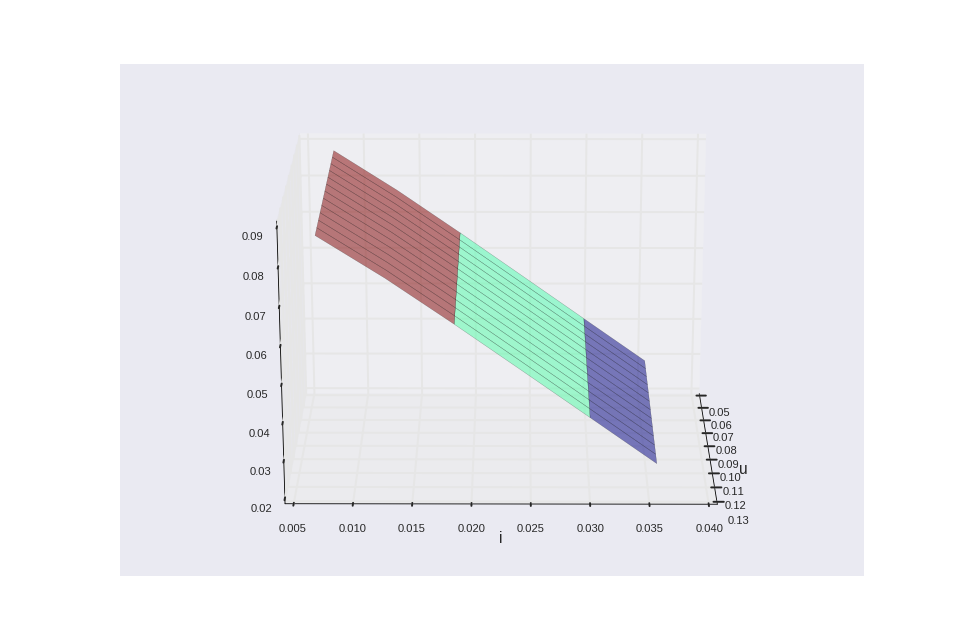

In [26]:
# plot value function
fig = plt.figure(4)
ax = fig.add_subplot(111, projection='3d')
ug, ig = np.meshgrid(u_grid, i_grid)
ax.plot_surface(ug,
                ig,
                S_star.T,
                rstride=2, cstride=2,
                cmap=cm.jet,
                alpha=0.5,
                linewidth=0.25)
#ax.set_zlim(, 200)
ax.set_xlabel('u', fontsize=14)
ax.set_ylabel('i', fontsize=14)
plt.show()

<IPython.core.display.Javascript object>


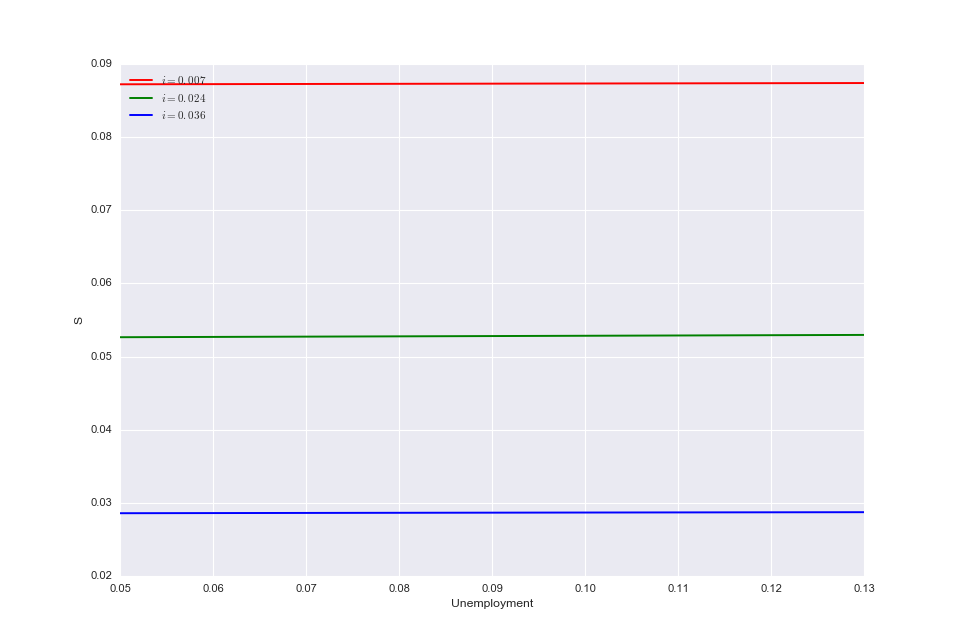

In [165]:
plt.figure(5)
plt.plot(u_grid,S_star[:,0],'-r', label=r'$i = %.3f$' % i_grid[0])
plt.plot(u_grid,S_star[:,3],'-g', label=r'$i = %.3f$' % i_grid[3])
plt.plot(u_grid,S_star[:,5],'-b', label=r'$i = %.3f$' % i_grid[5])
plt.legend(loc='upper left')
plt.xlabel('Unemployment')
plt.ylabel('S')
plt.show()

Now that we have the optimal value function, we can try to simulate the model using the historical data. That is, given interest rates from the data and the optimal value function we can compute the model implied unemployment path.



In [166]:
# First we interpolate the optimal value function
# S_star_interp = interp.interp2d(u_grid, i_grid, S_star.T, kind='cubic')
S_star_interp = interp.RectBivariateSpline(u_grid,i_grid,S_star).ev

# Then we use the interpolation to compute theta resulting from the optimal value function
def theta_star(i,u): 
    return opt.root(lambda x: k - beta * min(p(x)/x,1) * eta * S_star_interp(u,i), 1, method='lm').x

def u_hat_star(u, theta):
    return u + (1 - u) * delta - u * min(p(theta),1)

u_sim = np.empty(len(u_data))

u_sim[0] = u_data[28] # Initializing u with the first observation in the data (datd first index is 28 ==> should change it)

# Computes u_hat based on the previous period computed u and observed i
for jj in range(1,len(u_sim)):
    u_sim[jj] = u_hat_star(u_sim[jj-1],theta_star((i_data[28 + jj]+1)**4-1,u_sim[jj-1]))

Then we plot both observed and simulated u

<IPython.core.display.Javascript object>


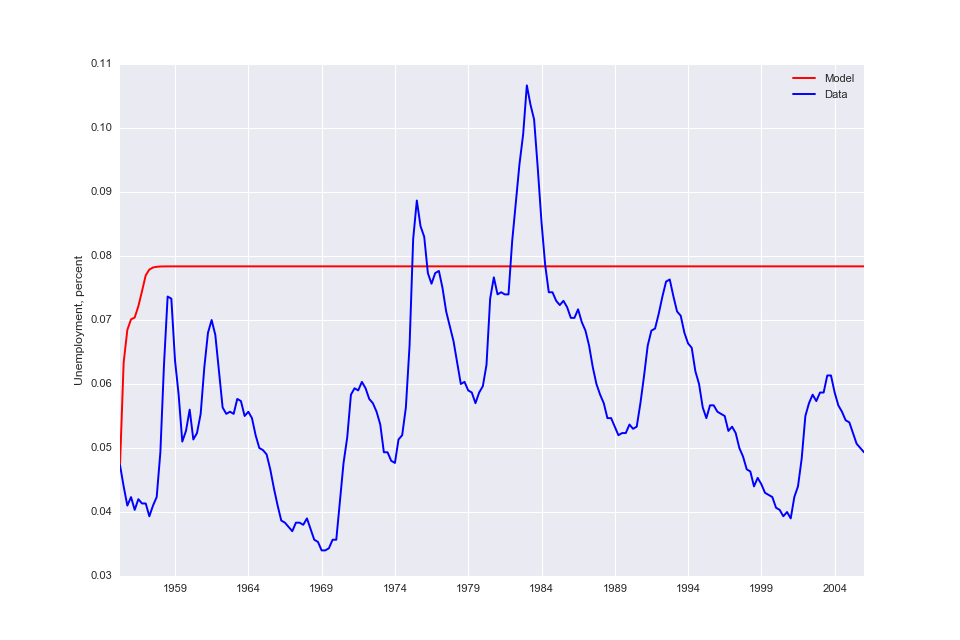

In [167]:
plt.figure()
dates = pd.date_range(start='1955-01-01',end='2005-12-31',freq='Q')
plt.plot(dates, u_sim, 'r-', label='Model')
plt.plot(dates, u_data, 'b-', label='Data')
#plt.xlim(0.01,0.15)
#plt.ylim(-0.5,2)
plt.ylabel('Unemployment, percent')
plt.legend(loc='best')
plt.show()

In [166]:
u_sim[0]

0.047333

In [229]:
theta_star((i_data[28 + 1]+1)**4-1,u_sim[0])

array([ 7948.60997812])